<a href="https://colab.research.google.com/github/geijinchan/MultiModal-RAG-trying-wiht-open-source-models/blob/main/MultiModal_RAG_trying_wiht_open_source_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multimodal RAG App for Video Processing with LlamaIndex and LaneDB

1. llamaindex Framework
2. Lancedb Vector Database
3. LLM MultiModalAi GPT-4V or Google-gemini-pro-vision

### Steps Need to follow:
1. Download video from Youtube, process and store it.
2. Build Multi-Modal index and vector store for both text and images.
3. Retrieve relenavet images and context, use both to augment the prompt.
4. Using GPT4V for reasoning the correlation between the input query and augmented data and generate final response.

#### Installing Necessary Dependencies

In [ ]:
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-embeddings-clip
%pip install git+https://github.com/openai/CLIP.git
!pip install llama-index-readers-file
!pip install llama-index-embeddings-openai
%pip install lancedb
%pip install llama-index lancedb transformers ftfy regex tqdm
%pip install moviepy
%pip install pytube
%pip install pytubefix
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install ftfy regex tqdm
%pip install openai-whisper

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dnmrdlw0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dnmrdlw0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.4/187.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisp

In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
from pytube import YouTube
from pytubefix import YouTube
from pytubefix.cli import on_progress
from moviepy.editor import VideoFileClip
import speech_recognition as sr
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pytube'

ffmpeg-library enables you to use FFmpeg in Python to manipulate various media files for different purposes like building comprehensive multimedia applications, preprocessing media files.


Pydub is a Python library for audio manipulation, enabling easy loading, editing, and exporting of audio files in various formats with minimal code.

SoundFile is a Python library for reading from and writing to audio files, supporting many formats through the libsndfile library, ideal for high-quality audio processing.

FTFY (Fix Text For You) is a Python library that fixes broken Unicode text and mojibake (garbled text due to encoding issues), making text legible again.

OpenAI Whisper is a robust, multilingual speech recognition model developed by OpenAI. It converts speech into text and supports various languages with high accuracy.

pprint is a Python module that provides a capability to "pretty-print" complex data structures in a well-formatted and more readable way than the basic print function.

In [ ]:
import os
from google.colab import userdata
OPENAI_API_TOKEN=userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [ ]:
video_url='https://youtu.be/3dhcmeOTZ_Q'
output_video_path = "/content/video_data/"

# From the video lets collect images, audio and text
output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"

!mkdir mixed_data

filepath=output_video_path + "input_vid.mp4"
print(filepath)

/content/video_data/input_vid.mp4


#### 1.1 Downloading the video

Pytube is a Python library used for downloading videos from YouTube. It supports downloading in various formats, resolutions, and also direct audio extraction.

In [ ]:
def download_video(url,output_path):
  yt = YouTube(video_url, on_progress_callback = on_progress)
  metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
  yt.streams.get_highest_resolution().download(output_path=output_video_path,
                                               filename="input_vid.mp4")
  return metadata

#### 1.2 Video to image

MoviePy is a Python library for video editing, enabling cutting, concatenations, title insertions, video compositing, and effects like animations or color grading.

In [ ]:
def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2   #0.2 frames per second (fps) is equal to 2/10 of a frame per second
  )

#### 1.3 Video to audio

In [ ]:
def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

#### 1.4 Audio to text

The SpeechRecognition library in Python allows you to convert spoken language into text using various engines and APIs, such as Google Speech Recognition, IBM Speech to Text, etc.

In [ ]:
def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text


In [ ]:
metadata_vid = download_video(video_url, output_video_path)
video_to_images(filepath,output_folder)
video_to_audio(filepath,output_audio_path)
text_data=audio_to_text(output_audio_path)
text_data

Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.
MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 81.9MiB/s]


" Lanyard regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here, so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see expressed as f of x, the function of the input variable. x on the other hand, would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m or beta 1 coefficient controls the slope of the line. The b or the beta 0 controls the intercept of the line. In machine learning, we also know it as the bias. These two coefficients are what we are solving for in linear re

In [ ]:
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()
os.remove(output_audio_path)
print("Audio file removed")

Text data saved to file
Audio file removed


## 2 Build Multi-Modal index and vector store for both text and images.

#### Load the data

To proceed with embedding the extracted frames and storing them as vectors in FAISS, we'll use a model like CLIP to embed both images (frames) and text data. Then, we'll store these embeddings in FAISS for efficient retrieval.

### Step-by-Step Guide:
1. Embed Images (Frames) Using CLIPbed Images (Frames) Using CLIP

CLIP (Contrastive Language–Image Pretraining) is an open-source model that can generate embeddings for both images and text. We'll use it to embed the extracted frames.

## Final working

In [6]:
# Only text part is working

"""# Image processing functions
def load_and_group_images(directory, batch_size=3):
    grouped_images = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]
    return grouped_images

def encode_image_batch(image_batch):
    inputs = processor(images=image_batch, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy()

# Text processing functions
def text_to_wordList(text_data):
    words = word_tokenize(text_data)
    cleaned_words = [word for word in words if word not in {',', '.'}]
    max_words_per_list = 40
    return [cleaned_words[i:i + max_words_per_list] for i in range(0, len(cleaned_words), max_words_per_list)]

def encode_and_normalize_text_lists(text_lists):
    text_chunks = [" ".join(sublist) for sublist in text_lists]
    inputs = processor(text=text_chunks, return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs).cpu().numpy()
    text_features /= np.linalg.norm(text_features, axis=1, keepdims=True)
    return text_features

# Combined embedding and indexing
def create_combined_index(image_directory, text_data):
    # Process images
    grouped_images = load_and_group_images(image_directory)
    image_embeddings = np.vstack([encode_image_batch(img_batch) for img_batch in grouped_images])

    # Process text
    word_lists = text_to_wordList(text_data)
    text_embeddings = encode_and_normalize_text_lists(word_lists)

    # Combine embeddings
    combined_embeddings = np.hstack([text_embeddings, image_embeddings.reshape(text_embeddings.shape[0], -1)])

    # Create Faiss index
    dimension = combined_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(combined_embeddings)

    return index, word_lists, grouped_images

# Query function
def query_combined_index(index, query_text, k=5, threshold=0.5):
    query_embedding = encode_and_normalize_text_lists([[query_text]])
    query_embedding_padded = np.hstack([query_embedding, np.zeros((1, index.d - query_embedding.shape[1]))])
    D, I = index.search(query_embedding_padded, k)
    return [(i, D[0][idx]) for idx, i in enumerate(I[0]) if D[0][idx] > threshold]

# Retrieval function
def retrieve_text_and_images(indices, word_lists, grouped_images):
    results = []
    for idx, similarity in indices:
        text = ' '.join(word_lists[idx])
        images = grouped_images[idx]
        results.append({
            'text': text,
            'images': images,
            'similarity': similarity
        })
    return results

# Main execution

# Create the combined index
index, word_lists, grouped_images = create_combined_index(image_files, text_data)

# Example query
query_text = "O'reilly"
matched_indices = query_combined_index(index, query_text)

# Retrieve results
results = retrieve_text_and_images(matched_indices, word_lists, grouped_images)

# Print results
for i, result in enumerate(results):
    print(f"Match {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Number of images: {len(result['images'])}")
    print(f"Similarity: {result['similarity']:.4f}")
    print()"""

'# Image processing functions\ndef load_and_group_images(directory, batch_size=3):\n    grouped_images = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]\n    return grouped_images\n\ndef encode_image_batch(image_batch):\n    inputs = processor(images=image_batch, return_tensors="pt", padding=True, truncation=True)\n    with torch.no_grad():\n        image_features = model.get_image_features(**inputs)\n    return image_features.cpu().numpy()\n\n# Text processing functions\ndef text_to_wordList(text_data):\n    words = word_tokenize(text_data)\n    cleaned_words = [word for word in words if word not in {\',\', \'.\'}]\n    max_words_per_list = 40\n    return [cleaned_words[i:i + max_words_per_list] for i in range(0, len(cleaned_words), max_words_per_list)]\n\ndef encode_and_normalize_text_lists(text_lists):\n    text_chunks = [" ".join(sublist) for sublist in text_lists]\n    inputs = processor(text=text_chunks, return_tensors="pt", padding=True, truncation=True, ma

## Copy

In [ ]:
# Working fine

%pip install annoy
%pip install sentence-transformers
%pip install moviepy
%pip install pytube
%pip install pytubefix
%pip install pydub
%pip install openai-whisper
%pip install SpeechRecognition
%pip install faiss-cpu

In [6]:
# Working fine

import speech_recognition as sr
import os
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import torch
import glob
from annoy import AnnoyIndex
from moviepy.editor import VideoFileClip
from pathlib import Path
from pytube import YouTube
from pytubefix import YouTube
from pytubefix.cli import on_progress
from moviepy.editor import VideoFileClip
import speech_recognition as sr
from pprint import pprint
from PIL import Image
 # Install the CPU version of Faiss
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import faiss
from tqdm import tqdm
from transformers import CLIPTokenizer
import numpy as np
import torch
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Working fine


video_url='https://youtu.be/3dhcmeOTZ_Q'
output_video_path = "/content/video_data/"

# From the video lets collect images, audio and text
output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"

!mkdir mixed_data

filepath=output_video_path + "input_vid.mp4"
print(filepath)


def download_video(url,output_path):
  yt = YouTube(video_url, on_progress_callback = on_progress)
  metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
  yt.streams.get_highest_resolution().download(output_path=output_video_path,
                                               filename="input_vid.mp4")
  return metadata


def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2   #0.2 frames per second (fps) is equal to 2/10 of a frame per second
  )

def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text


metadata_vid = download_video(video_url, output_video_path)
video_to_images(filepath,output_folder)
video_to_audio(filepath,output_audio_path)
text_data=audio_to_text(output_audio_path)
text_data

with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()
os.remove(output_audio_path)
print("Audio file removed")
data_backup = text_data


/content/video_data/input_vid.mp4
Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.
MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 93.3MiB/s]


Text data saved to file
Audio file removed


Match 1:
Text: more depth If you want live instruction I also do teach on the O'Reilly platform Promotional link below I teach classes including machine learning from scratch probability and SQL Comment on what topics you would like to see next and
Number of images: 3
Image paths: [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2C50>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2C80>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2FB0>]
Similarity: 0.7903

Displaying images for Match 1:


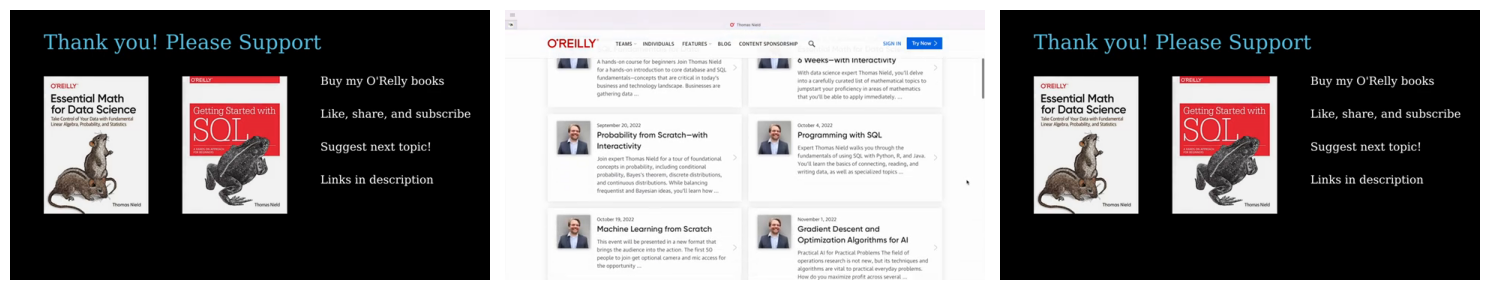

Match 2:
Text: I will see you again on 3 Minute Data Science
Number of images: 2
Image paths: [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2DD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2E30>]
Similarity: 0.7847

Displaying images for Match 2:


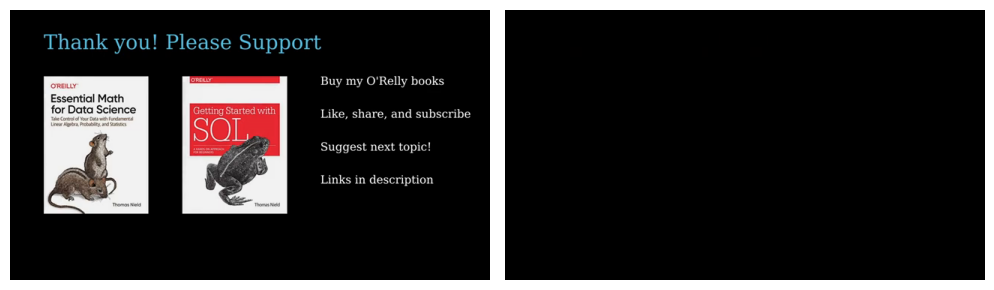

Match 3:
Text: training data set The training data set will then be used to fit the regression line The test data set will then be used to validate the regression line This is done to make sure that the regression performs well
Number of images: 3
Image paths: [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2470>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E1690>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E0D90>]
Similarity: 0.7537

Displaying images for Match 3:


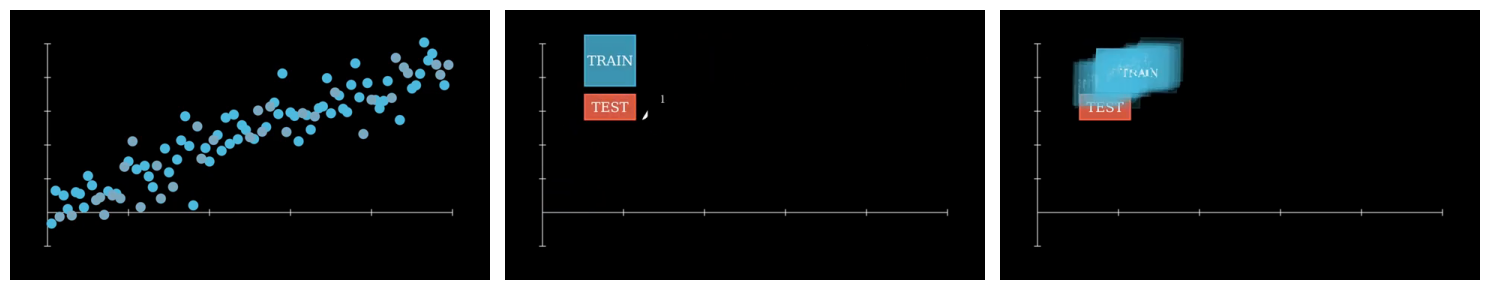

Match 4:
Text: may also see expressed as f of x the function of the input variable x on the other hand would serve as the input variable also called the independent variable It 's likely you 'll see the coefficients m and
Number of images: 3
Image paths: [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB13022C6D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB13022E9B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB13022C220>]
Similarity: 0.7479

Displaying images for Match 4:


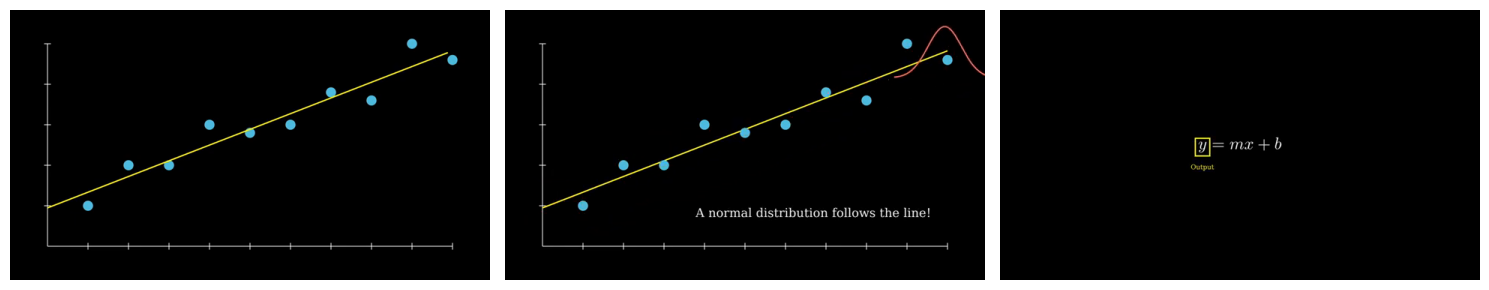

Match 5:
Text: on data it has not seen before The tricks used to evaluate the linear regression vary from the R square standard error of the estimate prediction intervals as well as statistical significance These are topics we will cover in future
Number of images: 3
Image paths: [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E0EB0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E0DF0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x7EB12D3E2BF0>]
Similarity: 0.7432

Displaying images for Match 5:


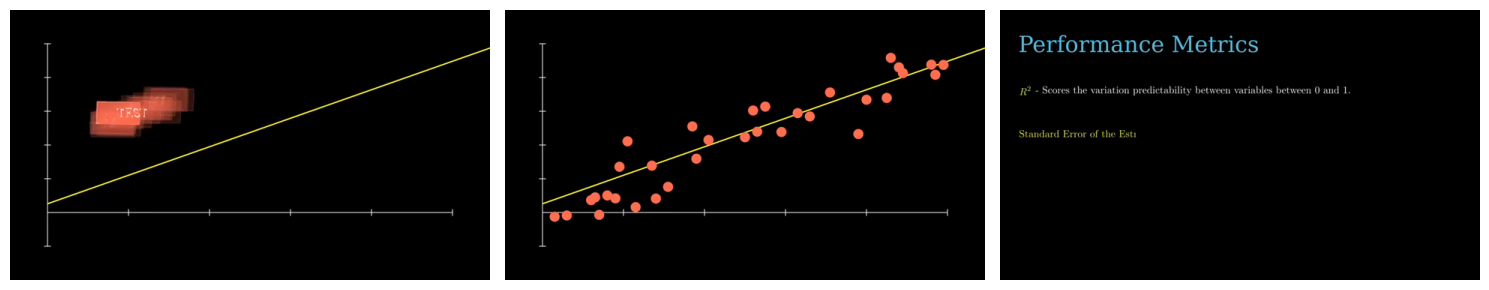

In [7]:
# Final working

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Image processing functions
def load_and_group_images(images, batch_size=3):
    grouped_images = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]
    return grouped_images

def encode_image_batch(image_batch):
    inputs = processor(images=image_batch, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy()

# Text processing functions
def text_to_wordList(text_data):
    words = word_tokenize(text_data)
    cleaned_words = [word for word in words if word not in {',', '.'}]
    max_words_per_list = 40
    return [cleaned_words[i:i + max_words_per_list] for i in range(0, len(cleaned_words), max_words_per_list)]

def encode_and_normalize_text_lists(text_lists):
    text_chunks = [" ".join(sublist) for sublist in text_lists]
    inputs = processor(text=text_chunks, return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs).cpu().numpy()
    text_features /= np.linalg.norm(text_features, axis=1, keepdims=True)
    return text_features

# Combined embedding and indexing
def create_combined_index(image_directory, text_data):
    # Process images
    grouped_images = load_and_group_images(image_directory)
    image_embeddings = np.vstack([encode_image_batch(img_batch) for img_batch in grouped_images])

    # Process text
    word_lists = text_to_wordList(text_data)
    text_embeddings = encode_and_normalize_text_lists(word_lists)

    # Combine embeddings
    combined_embeddings = np.hstack([text_embeddings, image_embeddings.reshape(text_embeddings.shape[0], -1)])

    # Create Faiss index
    dimension = combined_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(combined_embeddings)

    return index, word_lists, grouped_images

# Query function
def query_combined_index(index, query_text, k=5, threshold=0.5):
    query_embedding = encode_and_normalize_text_lists([[query_text]])
    query_embedding_padded = np.hstack([query_embedding, np.zeros((1, index.d - query_embedding.shape[1]))])
    D, I = index.search(query_embedding_padded, k)
    return [(i, D[0][idx]) for idx, i in enumerate(I[0]) if D[0][idx] > threshold]

# Retrieval function
def retrieve_text_and_images(indices, word_lists, grouped_images, image_files):
    results = []
    for idx, similarity in indices:
        text = ' '.join(word_lists[idx])
        images = grouped_images[idx]
        image_paths = image_files[idx*3:(idx+1)*3]  # Get the corresponding image file paths
        results.append({
            'text': text,
            'images': images,
            'image_paths': image_paths,
            'similarity': similarity
        })
    return results

# New function to display images
def display_images(images, num_cols=3):
    num_images = len(images)
    num_rows = (num_images - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    if num_rows == 1 and num_cols == 1:
        axes = np.array([axes])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.ravel()

    for i, img in enumerate(images):
        if isinstance(img, Image.Image):
            axes[i].imshow(img)
        elif isinstance(img, str):
            axes[i].imshow(Image.open(img))
        else:
            axes[i].imshow(img)  # Assume it's a numpy array or something imshow can handle
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


image_files = glob.glob("mixed_data/*.png")
image_files = natsorted(image_files)
images = [Image.open(file) for file in image_files]

# Create the combined index
index, word_lists, grouped_images = create_combined_index(images, text_data)

# Example query
query_text = "O'reilly"
matched_indices = query_combined_index(index, query_text)

# Retrieve results
results = retrieve_text_and_images(matched_indices, word_lists, grouped_images,images)

# Print results and display images
for i, result in enumerate(results):
    print(f"Match {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Number of images: {len(result['images'])}")
    print(f"Image paths: {result['image_paths']}")
    print(f"Similarity: {result['similarity']:.4f}")
    print()

    # Display the images
    print(f"Displaying images for Match {i+1}:")
    display_images(result['images'])